In [14]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
from matplotlib import pyplot
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn import tree
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor


In [3]:
weather=pd.read_csv('../data/weather.csv')
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather.set_index("date_time", inplace=True)
weather.head()

,max_temp,min_temp,precip
date_time,,,
2018-01-01 00:00:00,14.4,14.150,0.0
2018-01-01 01:00:00,14.4,14.275,0.0
2018-01-01 02:00:00,14.4,14.400,0.0
2018-01-01 03:00:00,14.4,14.400,0.0
2018-01-01 04:00:00,14.4,13.900,0.0


In [4]:
df_la=pd.read_csv('../data/LA.csv')
df_la["start_time"] = pd.to_datetime(df_la['start_time'])
df_la["end_time"] = pd.to_datetime(df_la['end_time'] ) 
df_la["trip_duration"] = pd.to_timedelta(df_la.trip_duration)
df_la.set_index("start_time", inplace=True)
df_la.head()

,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_duration,trip_duration_in_hours
start_time,,,,,,,,,
2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,Pershing Square,Grand & Olympic,0 days 00:21:00,0.350000
2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,Pershing Square,Grand & Olympic,0 days 00:20:00,0.333333
2018-01-01 00:06:00,2018-01-01 00:25:00,3063,3018,5753,Walk-up,Pershing Square,Grand & Olympic,0 days 00:19:00,0.316667
2018-01-01 00:13:00,2018-01-01 00:35:00,3018,3031,6220,Monthly Pass,Grand & Olympic,7th & Spring,0 days 00:22:00,0.366667
2018-01-01 00:14:00,2018-01-01 00:59:00,4204,4216,12436,Monthly Pass,Washington & Abbot Kinney,17th St / SMC E Line Station,0 days 00:45:00,0.750000


In [5]:
# calc demand
df = weather.copy()
df["demand"] = df_la.bike_id.resample("H").count()
df

,max_temp,min_temp,precip,demand
date_time,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25
2018-01-01 01:00:00,14.4,14.275,0.0,24
2018-01-01 02:00:00,14.4,14.400,0.0,12
2018-01-01 03:00:00,14.4,14.400,0.0,3
2018-01-01 04:00:00,14.4,13.900,0.0,4
...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13
2018-12-31 20:00:00,17.8,17.800,0.0,17
2018-12-31 21:00:00,16.7,16.700,0.0,26


In [6]:
# time, date features
df["season"] = df.index.month%12 // 3 + 1 
dummies = pd.get_dummies(df["season"]).rename(columns=lambda x: "season_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["season"], inplace=True, axis=1)

df["day_of_week"] = df.index.day_of_week
df["weekend"] = df.day_of_week.apply(lambda x: 1 if x >=4 else 0) #friday till sunday
df.drop("day_of_week", inplace=True, axis=1)

df["hour"] = df.index.hour 
df["time_of_day"] = df.hour.apply(lambda x: (x-1)//6 if x>0 else 3)
dummies = pd.get_dummies(df["time_of_day"]).rename(columns=lambda x: "time_of_day_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["time_of_day"], inplace=True, axis=1)
df.drop(["hour"], inplace=True, axis=1)

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
date_time,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,1
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,1,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,1,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,1,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,1


In [7]:
# lag features
df["lag_2"] = df.demand.shift(2) # demand in last hour before the prediction takes place
df["lag_3"] = df.demand.shift(3) # demand in last hour before the prediction takes place
df["lag_4"] = df.demand.shift(4) # demand in last hour before the prediction takes place
df.dropna(inplace=True)
df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,lag_2,lag_3,lag_4
date_time,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,14.4,13.9,0.0,4,1,0,0,0,0,1,0,0,0,12.0,24.0,25.0
2018-01-01 05:00:00,13.9,13.9,0.0,7,1,0,0,0,0,1,0,0,0,3.0,12.0,24.0
2018-01-01 06:00:00,14.4,14.4,0.0,13,1,0,0,0,0,1,0,0,0,4.0,3.0,12.0
2018-01-01 07:00:00,13.9,13.9,0.0,10,1,0,0,0,0,0,1,0,0,7.0,4.0,3.0
2018-01-01 08:00:00,12.2,12.2,0.0,22,1,0,0,0,0,0,1,0,0,13.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.7,0.0,13,1,0,0,0,0,0,0,0,1,36.0,61.0,67.0
2018-12-31 20:00:00,17.8,17.8,0.0,17,1,0,0,0,0,0,0,0,1,25.0,36.0,61.0
2018-12-31 21:00:00,16.7,16.7,0.0,26,1,0,0,0,0,0,0,0,1,13.0,25.0,36.0


In [8]:
#special days
#one hour before to one after 
df['event'] = 0
df.loc['2018-09-30 07:00:00':'2018-09-30 16:00:00','event'] = 1
df.loc['2018-12-02 08:00:00':'2018-12-02 16:00:00','event'] = 1
df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,lag_2,lag_3,lag_4,event
date_time,,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,14.4,13.9,0.0,4,1,0,0,0,0,1,0,0,0,12.0,24.0,25.0,0
2018-01-01 05:00:00,13.9,13.9,0.0,7,1,0,0,0,0,1,0,0,0,3.0,12.0,24.0,0
2018-01-01 06:00:00,14.4,14.4,0.0,13,1,0,0,0,0,1,0,0,0,4.0,3.0,12.0,0
2018-01-01 07:00:00,13.9,13.9,0.0,10,1,0,0,0,0,0,1,0,0,7.0,4.0,3.0,0
2018-01-01 08:00:00,12.2,12.2,0.0,22,1,0,0,0,0,0,1,0,0,13.0,7.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.7,0.0,13,1,0,0,0,0,0,0,0,1,36.0,61.0,67.0,0
2018-12-31 20:00:00,17.8,17.8,0.0,17,1,0,0,0,0,0,0,0,1,25.0,36.0,61.0,0
2018-12-31 21:00:00,16.7,16.7,0.0,26,1,0,0,0,0,0,0,0,1,13.0,25.0,36.0,0


In [9]:
df["weekend_x_lag_2"] = df.weekend * df.lag_2
df["weekend_x_lag_3"] = df.weekend * df.lag_3
df["weekend_x_lag_4"] = df.weekend * df.lag_4

df["diff_lag_2_lag_3"] = df.lag_2 - df.lag_3
df["diff_lag_3_lag_4"] = df.lag_3 - df.lag_4
df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,...,time_of_day_3,lag_2,lag_3,lag_4,event,weekend_x_lag_2,weekend_x_lag_3,weekend_x_lag_4,diff_lag_2_lag_3,diff_lag_3_lag_4
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,14.4,13.9,0.0,4,1,0,0,0,0,1,...,0,12.0,24.0,25.0,0,0.0,0.0,0.0,-12.0,-1.0
2018-01-01 05:00:00,13.9,13.9,0.0,7,1,0,0,0,0,1,...,0,3.0,12.0,24.0,0,0.0,0.0,0.0,-9.0,-12.0
2018-01-01 06:00:00,14.4,14.4,0.0,13,1,0,0,0,0,1,...,0,4.0,3.0,12.0,0,0.0,0.0,0.0,1.0,-9.0
2018-01-01 07:00:00,13.9,13.9,0.0,10,1,0,0,0,0,0,...,0,7.0,4.0,3.0,0,0.0,0.0,0.0,3.0,1.0
2018-01-01 08:00:00,12.2,12.2,0.0,22,1,0,0,0,0,0,...,0,13.0,7.0,4.0,0,0.0,0.0,0.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.7,0.0,13,1,0,0,0,0,0,...,1,36.0,61.0,67.0,0,0.0,0.0,0.0,-25.0,-6.0
2018-12-31 20:00:00,17.8,17.8,0.0,17,1,0,0,0,0,0,...,1,25.0,36.0,61.0,0,0.0,0.0,0.0,-11.0,-25.0
2018-12-31 21:00:00,16.7,16.7,0.0,26,1,0,0,0,0,0,...,1,13.0,25.0,36.0,0,0.0,0.0,0.0,-12.0,-11.0


<AxesSubplot:>

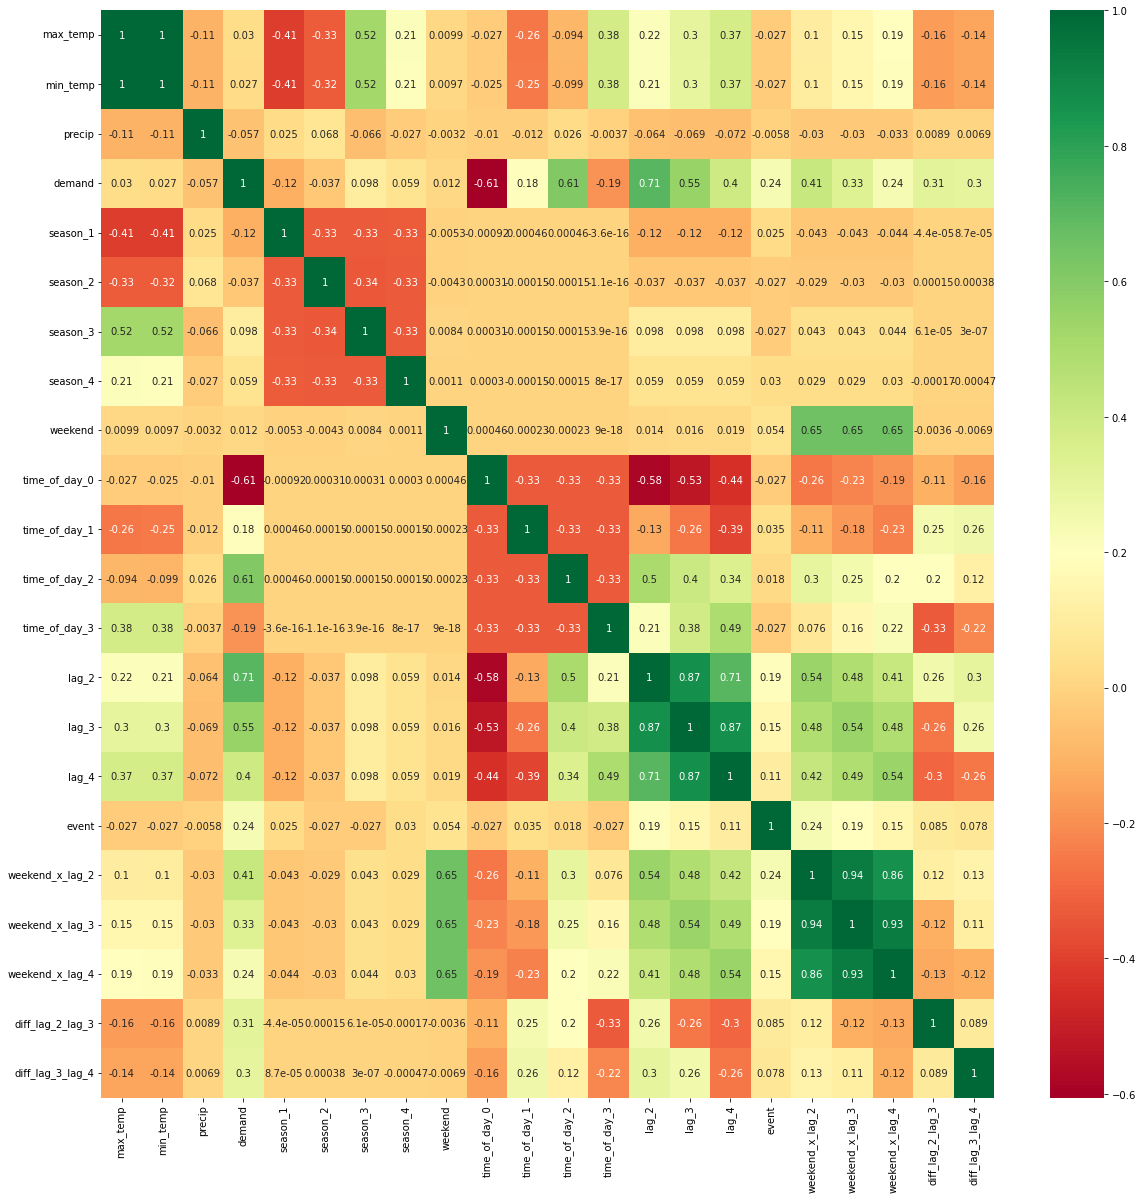

In [10]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [11]:
#scale
X = df.drop(["demand"],axis=1).copy()
y = df.demand

In [12]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_train)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)
X_scaled_df.head()

,max_temp,min_temp,precip,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,...,time_of_day_3,lag_2,lag_3,lag_4,event,weekend_x_lag_2,weekend_x_lag_3,weekend_x_lag_4,diff_lag_2_lag_3,diff_lag_3_lag_4
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-03 01:00:00,-0.485010,-0.474020,-0.122078,1.766839,-0.578292,-0.585829,-0.579297,-0.869864,1.746680,-0.576534,...,-0.574022,-1.005347,-0.491789,-0.661885,-0.042403,-0.569244,-0.570414,-0.568046,-0.986462,0.335091
2018-03-02 08:00:00,-1.172908,-1.160531,-0.122078,-0.565982,1.729229,-0.585829,-0.579297,1.149605,-0.572515,1.734503,...,-0.574022,-0.936604,-1.076339,-1.106319,-0.042403,-0.272459,-0.422698,-0.458392,0.267448,0.070105
2018-03-11 00:00:00,-0.902662,-0.890830,8.191459,-0.565982,1.729229,-0.585829,-0.579297,1.149605,-0.572515,-0.576534,...,1.742094,-1.108460,-1.145109,-1.174693,-0.042403,-0.457950,-0.496556,-0.531495,0.069463,0.070105
2018-11-09 09:00:00,-0.337604,-0.326911,-0.122078,-0.565982,-0.578292,-0.585829,1.726230,1.149605,-0.572515,1.734503,...,-0.574022,0.128898,-0.491789,-1.072131,-0.042403,0.877585,0.205095,-0.421841,1.191383,1.130050
2018-03-21 01:00:00,-0.755256,-0.743721,-0.122078,-0.565982,1.729229,-0.585829,-0.579297,-0.869864,1.746680,-0.576534,...,-0.574022,-0.970976,-1.007568,-0.388387,-0.042403,-0.569244,-0.570414,-0.568046,0.069463,-1.188579


In [ ]:
#Knn

In [96]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

Text(0, 0.5, 'Mean squared error')

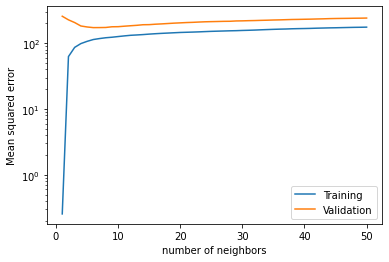

In [97]:
err_train = []
err_cv = []

for n in range(50):
    
    model = KNeighborsRegressor(n_neighbors = n+1)
    model.fit(X_train_2,y_train_2)
    
    pred_train=model.predict(X_train_2)
    err_train.append(mean_squared_error(y_train_2,pred_train))
    
    pred_val=model.predict(X_val)
    err_cv.append(mean_squared_error(y_val,pred_val))
    
plt.semilogy(range(1,51), err_train, range(1,51), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("number of neighbors")
plt.ylabel("Mean squared error")

(50, 270.0)

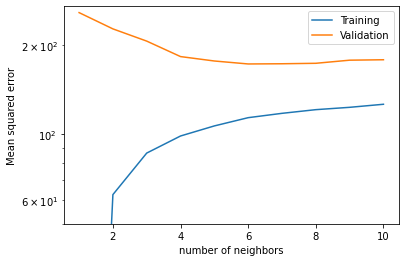

In [98]:
plt.semilogy(range(1,11), err_train[:10], range(1,11), err_cv[:10])
plt.legend(["Training", "Validation"])
plt.xlabel("number of neighbors")
plt.ylabel("Mean squared error")
plt.ylim([5*10**1,2.7*10**2])

In [99]:
KNN = KNeighborsRegressor(n_neighbors=6)
KNN.fit(X_scaled,y_train)

KNeighborsRegressor(n_neighbors=6)

In [81]:
#other

In [83]:
def find_params(params,model,X_train, y_train):
    
    grid = GridSearchCV(estimator=model, param_grid = params)
    grid.fit(X_train, y_train)
    
    print("score:",grid.best_score_)
    print("best parameters: ",grid.best_params_)
    
    return grid

In [569]:
params={'max_depth': [8,10,12],
                    'n_estimators': [300,400,500],
                    'min_samples_split':[15,20,25],
                    'min_samples_leaf':[2,4,6]}
model=RandomForestRegressor()
RFR=find_params(params,model,X_train,y_train)

score: 0.8241715196815363
best parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 400}


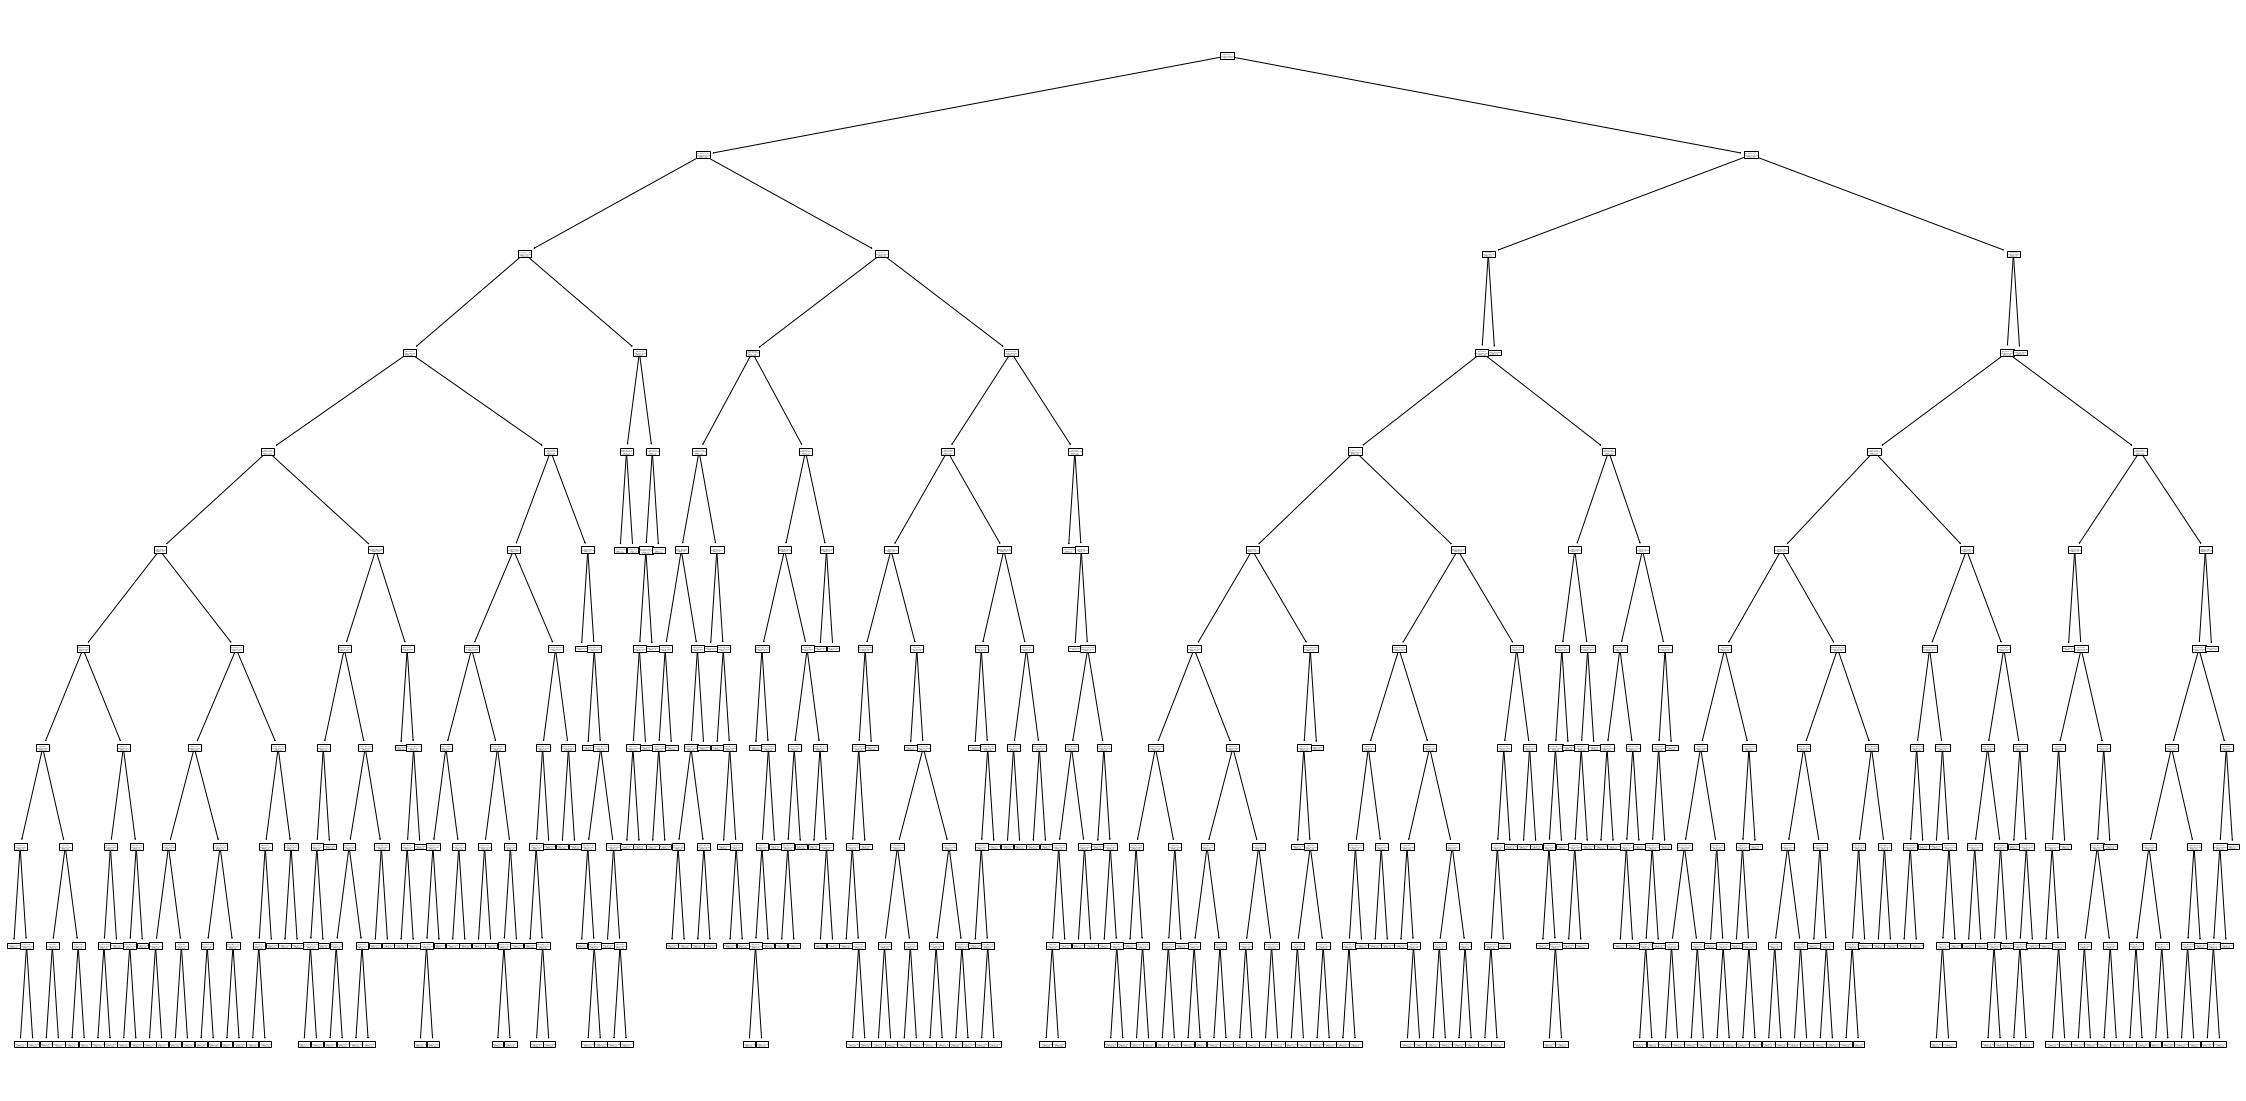

In [570]:
plt.figure(figsize=(40,20))
tree.plot_tree(RFR.best_estimator_.estimators_[0], feature_names = X.columns)
plt.show()

In [511]:
params = {'alpha':[0.005, 0.01, 0.05, 0.1],
                    'max_iter':[4000,5000,6000]}
model = ElasticNet()
EL=find_params(params,model,X_scaled,y_train)

score: 0.7657946595340788
best parameters:  {'alpha': 0.005, 'max_iter': 4000}


In [510]:
params = {"n_estimators" : [50,100,150],
                  "base_estimator__max_depth" : [10,12,15],
                  "base_estimator__min_samples_split" : [2, 5, 10, 12, 15, 20]}
model = BaggingRegressor(tree.DecisionTreeRegressor())
BR = find_params(params,model,X_train,y_train)

score: 0.8261434060820798
best parameters:  {'base_estimator__max_depth': 10, 'base_estimator__min_samples_split': 15, 'n_estimators': 50}


## Evaluation

In [50]:
scaler = StandardScaler()
X_scaled_test=scaler.fit_transform(X_test)

In [52]:
def plot_true_vs_prediction(y_pred,y_test):
    y_pred_series = pd.Series(np.array(y_pred) , index =y_test.index) 
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    fig,ax = plt.subplots(figsize=(20,10), dpi= 80) 
    ax.plot(y_test_sorted, label="true",linewidth=2,color="tab:gray")
    ax.plot(y_pred_series_sorted, label="prediction", linewidth=1,alpha=0.6,color="tab:blue")
    ax.set_ylabel('Bike Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()
    
    print ("R^2 score:",r2_score(y_test,y_pred))
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
    print("Root Mean Squared Error:",mean_squared_error(y_test,y_pred)**0.5)

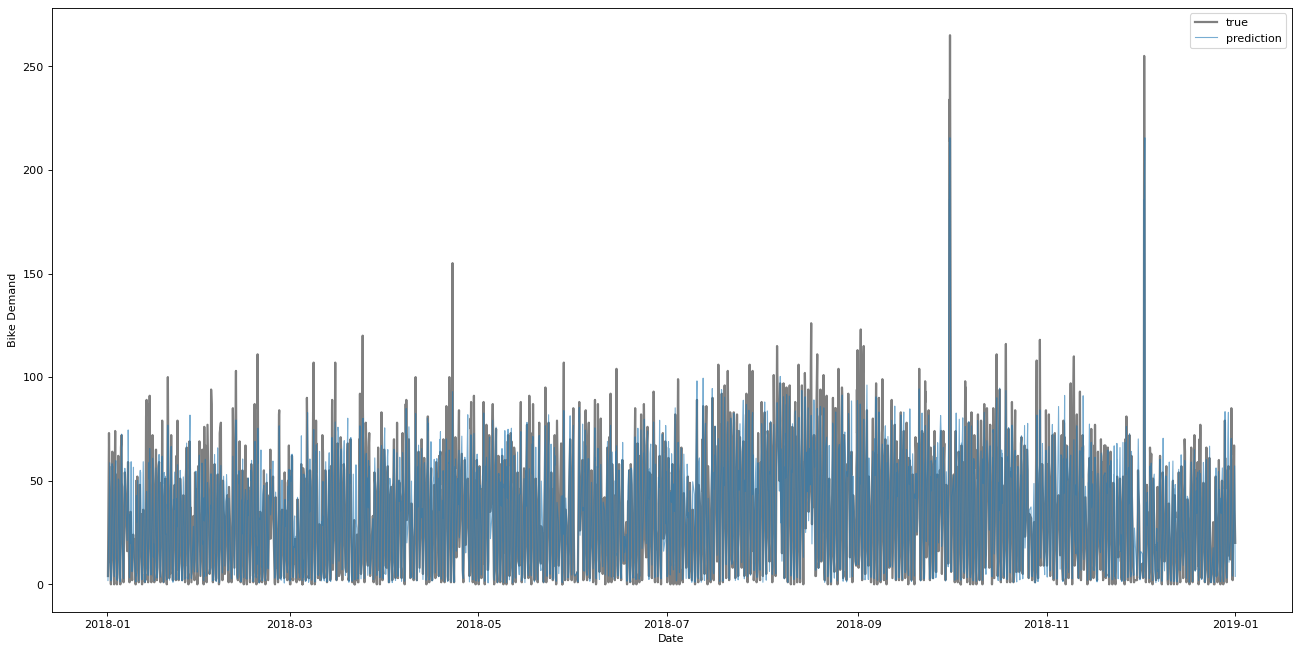

R^2 score: 0.795355265250186
Mean Absolute Error: 8.670980839994924
Root Mean Squared Error: 13.226020214308642


In [100]:
y_pred_KNN = KNN.predict(X_scaled_test)

plot_true_vs_prediction(y_pred_KNN,y_test)

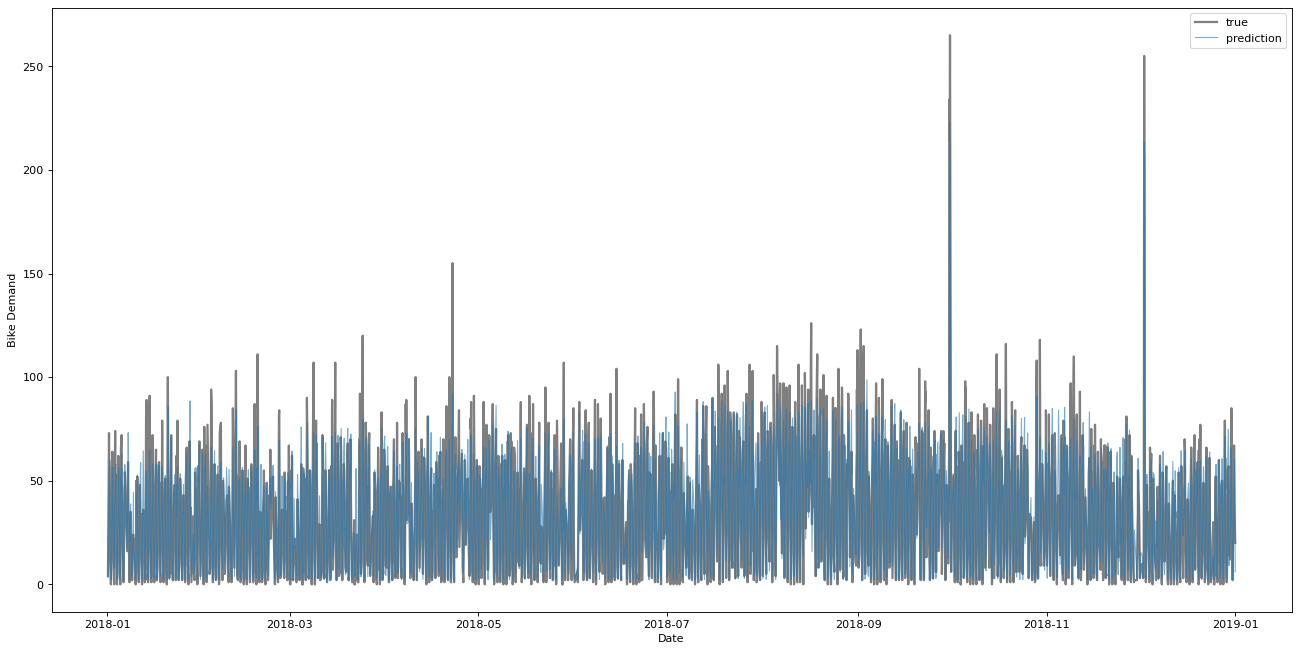

R^2 score: 0.8161071321338927
Mean Absolute Error: 8.253736138086644
Root Mean Squared Error: 12.537511298354188


In [577]:
y_pred_RFR = RFR.predict(X_test)

plot_true_vs_prediction(y_pred_RFR,y_test)

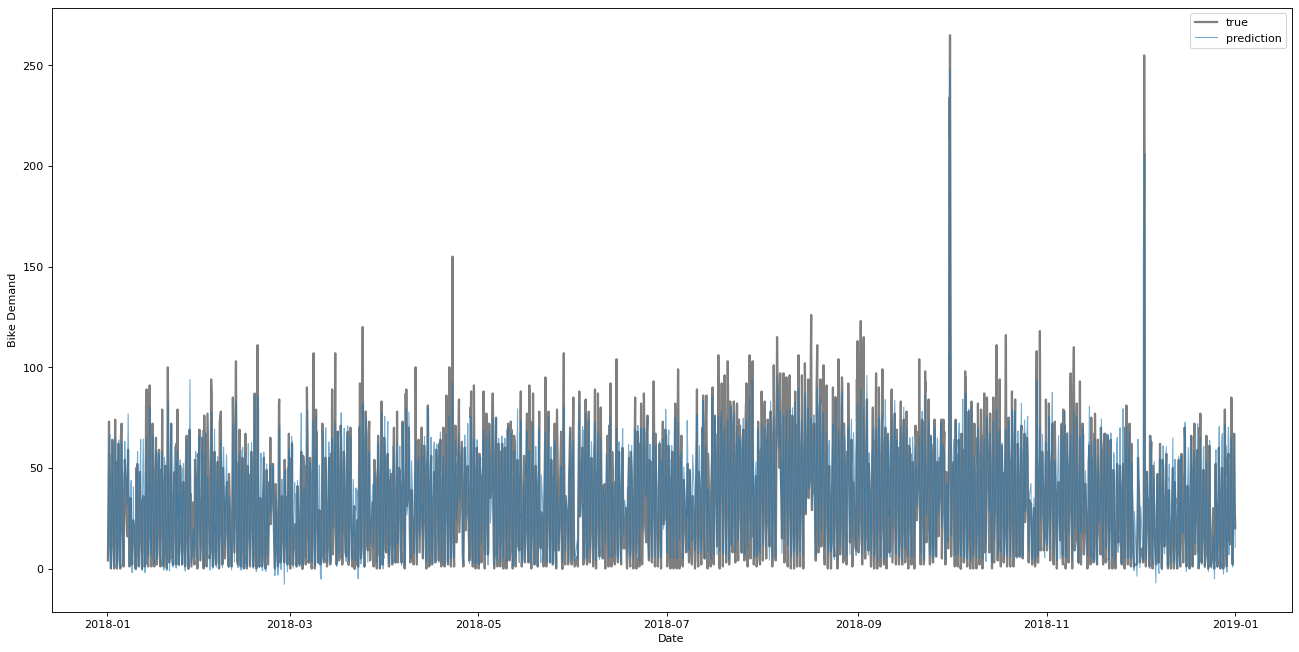

R^2 score: 0.7597900724366858
Mean Absolute Error: 10.275721187016188
Root Mean Squared Error: 14.329280051933594


In [578]:
y_pred_EL = EL.predict(X_scaled_test)

plot_true_vs_prediction(y_pred_EL,y_test)

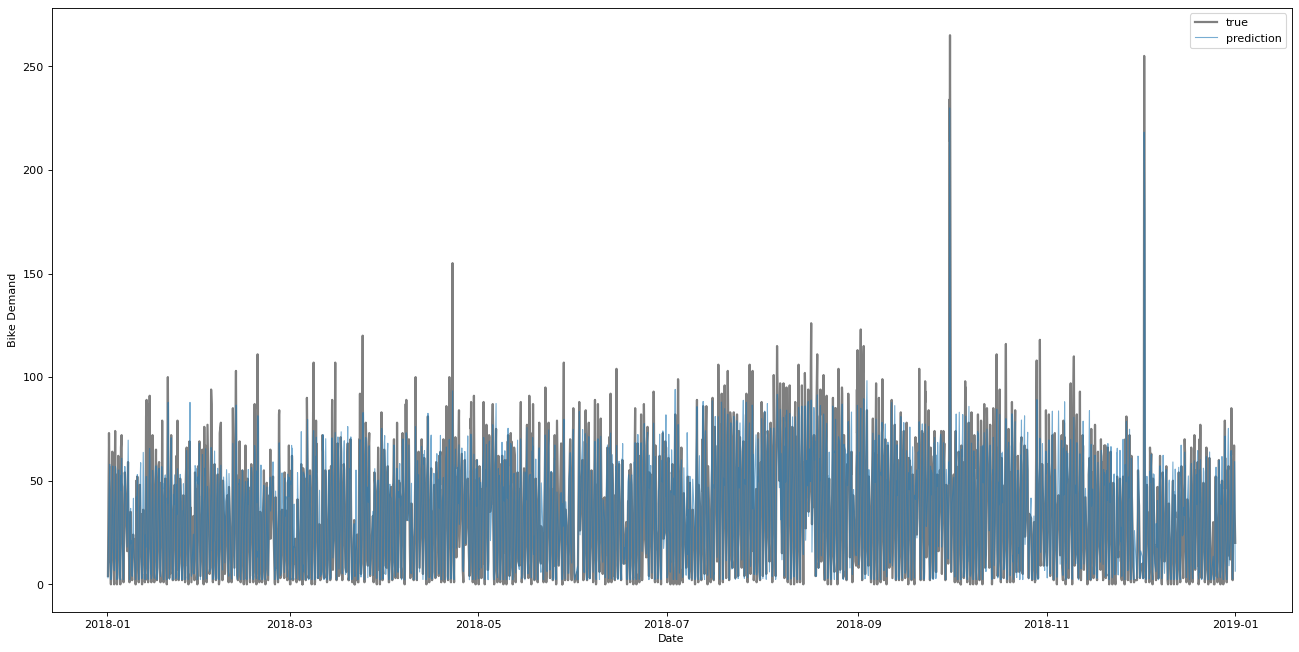

R^2 score: 0.8214966124760613
Mean Absolute Error: 8.236039185922007
Root Mean Squared Error: 12.352422154856882


In [579]:
y_pred_BR = BR.predict(X_test)

plot_true_vs_prediction(y_pred_BR,y_test)